# GroupE : Segmentation using DeepLabV3+ -- Inference

## Pretrained models (its frozen inference graph)

In [1]:
import glob
pascal_train_aug = "./models/research/deeplab/originalPretrainedModels/deeplabv3_mnv2_pascal_train_aug/frozen_inference_graph.pb"
pascal_train_aug_8bit = "./models/research/deeplab/originalPretrainedModels/deeplabv3_mnv2_pascal_train_aug_8bit/frozen_inference_graph.tflite"
PRETRAIN_PASCAL = [f for f in glob.glob(pascal_train_aug)]
PRETRAIN_PASCAL_8BITS = [f for f in glob.glob(pascal_train_aug_8bit)]
for pbfile in PRETRAIN_PASCAL + PRETRAIN_PASCAL_8BITS:
#     print(pbfile)
    print(pbfile.split('/')[-2]+"/"+pbfile.split('/')[-1])

deeplabv3_mnv2_pascal_train_aug/frozen_inference_graph.pb
deeplabv3_mnv2_pascal_train_aug_8bit/frozen_inference_graph.tflite


## Import packages/modules

In [2]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## DeepLabModel Class for Inference

In [3]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, pbfile):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    if True:
        graph_def = tf.GraphDef()
        with open(pbfile, "rb") as f:
            graph_def.ParseFromString(f.read())
    else:
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
          if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
            file_handle = tar_file.extractfile(tar_info)
            graph_def = tf.GraphDef.FromString(file_handle.read())
            break

        tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  
  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    #print(seg_map.shape)
    #print(seg_map)
    return resized_image, seg_map

######## EO-class

def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')
  #print(colormap[label])
  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()



## Inference on one image using pre-trained model trained w/ Pascal VOC dataset

In [4]:
!wget -O test.jpg https://images.pexels.com/photos/242829/pexels-photo-242829.jpeg
filename = 'test.jpg'

--2019-11-29 18:12:06--  https://images.pexels.com/photos/242829/pexels-photo-242829.jpeg
Resolving images.pexels.com (images.pexels.com)... 104.17.208.102, 104.17.209.102
Connecting to images.pexels.com (images.pexels.com)|104.17.208.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2875097 (2.7M) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]   2.74M  3.48MB/s    in 0.8s    

2019-11-29 18:12:07 (3.48 MB/s) - ‘test.jpg’ saved [2875097/2875097]



In [5]:
LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', #0-4 
    'bottle', 'bus', 'car', 'cat', 'chair', #5-9
    'cow', 'diningtable', 'dog', 'horse', 'motorbike', #10-14
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv' #15-20
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

VOC Pascal Dataset based pre-trained models
model loaded successfully (deeplabv3_mnv2_pascal_train_aug)!
(342, 513)
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [14 14 14 ...  0 14 14]
 [14 14 14 ...  0  0 14]
 [14 14 14 ...  0  0  0]]


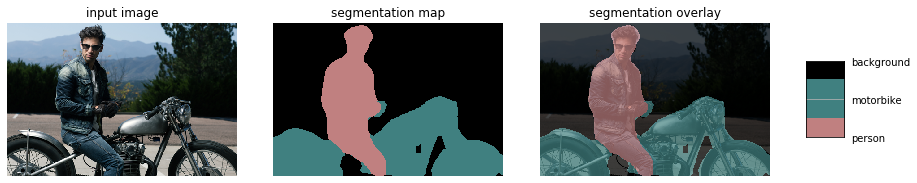

CPU times: user 2.57 s, sys: 509 ms, total: 3.08 s
Wall time: 2.35 s


In [6]:
%%time
print("VOC Pascal Dataset based pre-trained models")
for pbfile in PRETRAIN_PASCAL:
    arch = pbfile.split('/')[-2]
    MODEL = DeepLabModel(pbfile)
    print("model loaded successfully (%s)!" % arch)
    image = Image.open("test.jpg")
    resized_image, seg_map = MODEL.run(image)
    print(seg_map.shape)
    print(seg_map)
    vis_segmentation(resized_image, seg_map)

## Inferece on the Quantized Model

In [7]:
interpreter=tf.lite.Interpreter(model_path=pascal_train_aug_8bit)
interpreter.allocate_tensors()
input_details=interpreter.get_input_details()
output_details=interpreter.get_output_details()
h=input_details[0]['shape'][1]
w=input_details[0]['shape'][2]

In [8]:
image = Image.open("test.jpg").resize((h,w))
input_data=np.expand_dims(image, axis=0)

In [9]:
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data=interpreter.get_tensor(output_details[0]['index'])
results=np.squeeze(output_data)

In [10]:
FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

def vis_segmentationQ(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()

513 513
(1, 513, 513, 3)
(513, 513)
VOC Pascal Dataset based pre-trained models with 8-bit Quantization
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [14 14 14 ... 14 14 14]
 [14 14 14 ... 14 14 14]
 [14 14 14 ... 14 14 14]]


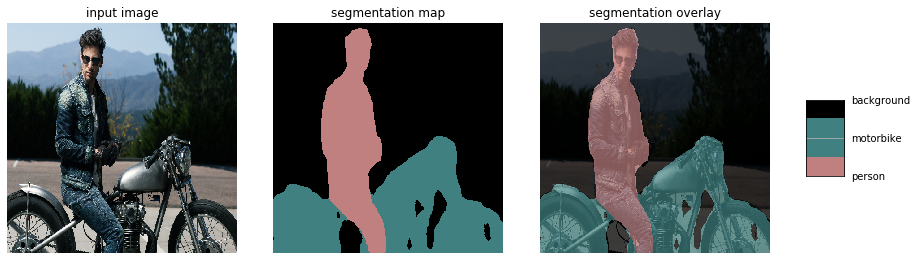

CPU times: user 586 ms, sys: 23.8 ms, total: 610 ms
Wall time: 614 ms


In [11]:
%%time
print(h,w)
print(input_data.shape) # (1,513,513,3)=(N,H,W,C)
print(results.shape)
print("VOC Pascal Dataset based pre-trained models with 8-bit Quantization")
print(results)
vis_segmentationQ(image, results)